# Overfitting Problem 실습 (데이터 크기 차이)

이번 실습에서는 **데이터 크기 차이에 따른 Overfitting** 현상을 체감해봅니다.
- 작은 데이터셋 (100개 샘플)
- 큰 데이터셋 (2000개 샘플)
- 같은 복잡한 모델을 적용하여 비교
- 학습 곡선을 통해 Overfitting 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. 데이터 준비 (작은 데이터셋 vs 큰 데이터셋)

In [2]:
# 작은 데이터셋 (100개)
X_small, y_small = make_moons(n_samples=100, noise=0.25, random_state=42)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# 큰 데이터셋 (2000개)
X_large, y_large = make_moons(n_samples=2000, noise=0.25, random_state=42)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_large, y_large, test_size=0.3, random_state=42)

# 스케일링
scaler_s = StandardScaler()
X_train_s = scaler_s.fit_transform(X_train_s)
X_test_s = scaler_s.transform(X_test_s)

scaler_l = StandardScaler()
X_train_l = scaler_l.fit_transform(X_train_l)
X_test_l = scaler_l.transform(X_test_l)

## 2. 복잡한 모델 정의

In [3]:
def build_complex_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(2,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 3. 작은 데이터셋 학습

In [4]:
model_small = build_complex_model()
history_small = model_small.fit(
    X_train_s, y_train_s, validation_data=(X_test_s, y_test_s),
    epochs=100, batch_size=16, verbose=0
)

## 4. 큰 데이터셋 학습

In [5]:
model_large = build_complex_model()
history_large = model_large.fit(
    X_train_l, y_train_l, validation_data=(X_test_l, y_test_l),
    epochs=100, batch_size=16, verbose=0
)

## 5. 학습 결과 비교 시각화

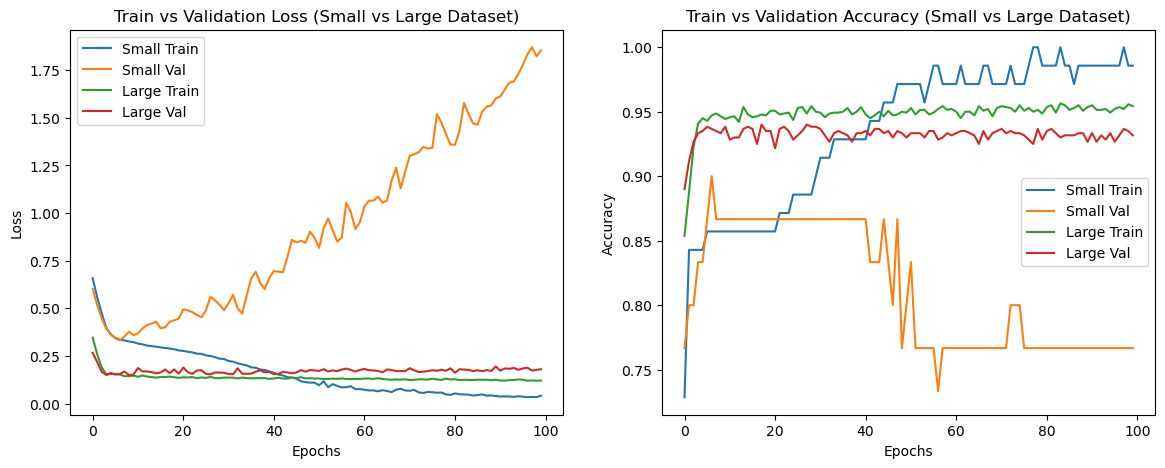

In [6]:
plt.figure(figsize=(14,5))

# Loss 비교
plt.subplot(1,2,1)
plt.plot(history_small.history["loss"], label="Small Train")
plt.plot(history_small.history["val_loss"], label="Small Val")
plt.plot(history_large.history["loss"], label="Large Train")
plt.plot(history_large.history["val_loss"], label="Large Val")
plt.title("Train vs Validation Loss (Small vs Large Dataset)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy 비교
plt.subplot(1,2,2)
plt.plot(history_small.history["accuracy"], label="Small Train")
plt.plot(history_small.history["val_accuracy"], label="Small Val")
plt.plot(history_large.history["accuracy"], label="Large Train")
plt.plot(history_large.history["val_accuracy"], label="Large Val")
plt.title("Train vs Validation Accuracy (Small vs Large Dataset)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## 6. 그래프 분석 및 도출점

### 손실(Loss) 그래프 분석

**작은 데이터셋 (Small Dataset)의 특징:**
- **훈련 손실 (Small Train)**: 에포크가 진행될수록 꾸준히 감소하여 약 0.1 이하로 매우 낮아짐
- **검증 손실 (Small Val)**: 초기에는 감소하다가 약 10-20 에포크 이후부터 급격히 증가하여 1.8 이상으로 치솟음
- **과적합 증상**: 훈련 손실과 검증 손실 간의 큰 격차가 발생 → 모델이 훈련 데이터의 노이즈까지 학습

**큰 데이터셋 (Large Dataset)의 특징:**
- **훈련 손실 (Large Train)**: 꾸준히 감소하여 약 0.1 이하로 낮게 유지
- **검증 손실 (Large Val)**: 훈련 손실과 거의 유사하게 함께 감소하여 약 0.15 정도로 낮게 유지
- **일반화 성공**: 훈련 손실과 검증 손실이 거의 일치 → 모델이 일반적인 패턴을 잘 학습

---

### 정확도(Accuracy) 그래프 분석

**작은 데이터셋 (Small Dataset)의 특징:**
- **훈련 정확도 (Small Train)**: 초기에 빠르게 상승하여 0.95 이상으로 매우 높게 유지 (최대 0.99)
- **검증 정확도 (Small Val)**: 초기에 0.90까지 상승하지만 이후 급격히 하락하여 0.75-0.87 사이에서 크게 변동
- **과적합 증상**: 훈련 정확도와 검증 정확도 간의 큰 차이 (약 0.15-0.20 차이)

**큰 데이터셋 (Large Dataset)의 특징:**
- **훈련 정확도 (Large Train)**: 초기에 빠르게 상승하여 약 0.94에 도달한 후 0.95 수준에서 안정적으로 유지
- **검증 정확도 (Large Val)**: 초기에 빠르게 상승하여 약 0.93에 도달한 후 0.93-0.94 수준에서 안정적으로 유지
- **일반화 성공**: 훈련 정확도와 검증 정확도가 거의 일치하며 높은 수준 유지

---

## 7. 주요 도출점

### 1. 데이터셋 크기의 중요성
- **충분한 데이터가 없으면** 복잡한 모델이 훈련 데이터의 노이즈까지 학습하여 과적합 발생
- **충분한 데이터가 있으면** 모델이 데이터의 일반적인 패턴을 학습하여 좋은 일반화 성능 달성

### 2. 과적합(Overfitting)의 특징
- **작은 데이터셋에서 발생하는 과적합:**
  - 훈련 손실은 낮지만 검증 손실은 급증
  - 훈련 정확도는 높지만 검증 정확도는 낮음
  - 훈련 데이터와 검증 데이터 간 성능 차이가 큼
- **과적합의 원인:**
  - 데이터가 부족하여 모델이 일반적인 패턴 대신 특정 데이터의 세부사항을 암기
  - 모델 복잡도가 데이터 크기에 비해 과도함

### 3. 일반화 성능(Generalization Performance)
- **큰 데이터셋의 장점:**
  - 훈련 손실과 검증 손실이 모두 낮고 유사하게 유지
  - 훈련 정확도와 검증 정확도가 모두 높고 유사하게 유지
  - 실제 환경에서 더 신뢰할 수 있는 예측 가능

### 4. 실무적 시사점
- **데이터 수집의 중요성**: 모델 성능 향상을 위해 충분한 양의 데이터 확보가 필수
- **모델 복잡도 조절**: 데이터 크기에 맞는 적절한 모델 복잡도 선택 필요
- **조기 종료(Early Stopping)**: 작은 데이터셋에서는 검증 손실이 증가하기 시작하는 시점에 학습 중단 고려
- **데이터 증강(Data Augmentation)**: 데이터가 부족할 때 데이터 증강 기법 활용 고려

### 5. 결론
이 실습을 통해 **데이터셋 크기가 모델의 일반화 성능에 결정적인 영향을 미친다**는 것을 확인할 수 있습니다. 작은 데이터셋으로는 복잡한 모델이 과적합에 빠지기 쉽지만, 충분한 데이터가 있으면 모델이 일반적인 패턴을 잘 학습하여 새로운 데이터에 대한 예측 성능이 향상됩니다.